Эксперимент
Начало обучения...
Epoch 1/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 67ms/step - loss: 6.4302 - val_loss: 0.9488 - learning_rate: 0.0010
Epoch 2/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.7055 - val_loss: 0.4216 - learning_rate: 0.0010
Epoch 3/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.4154 - val_loss: 0.3585 - learning_rate: 0.0010
Epoch 4/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.3273 - val_loss: 0.2718 - learning_rate: 0.0010
Epoch 5/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.2709 - val_loss: 0.1876 - learning_rate: 0.0010
Epoch 6/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.1896 - val_loss: 0.1609 - learning_rate: 0.0010
Epoch 7/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.1596 - val_loss: 0.0985 - learning_rate: 0.0010
Epoch 8/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.1190 - val_loss: 0.0766 - learning_rate: 0.0010
Epoch 9/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0969 - val_loss: 0.1105 - 

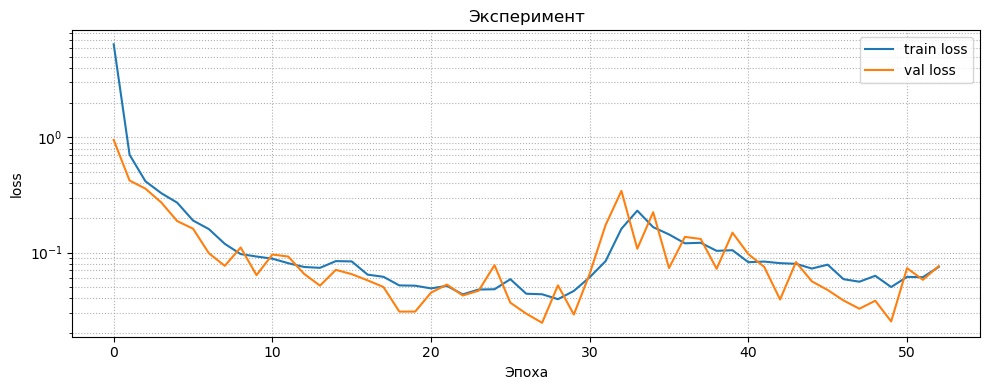

    Пример 1
    Уравнение: x^2 + (1.0) x + (-2.0) = 0
    Дискриминант D = 9.0
    Предсказанные корни: x1=-1.986755+0.018890j, x2=+1.071899-0.001057j
    Настоящие корни: a =+1.000000+0.000000j, b =-2.000000+0.000000j
    Пример 2
    Уравнение: x^2 + (4.0) x + (4.0) = 0
    Дискриминант D = 0.0
    Предсказанные корни: x1=-1.640560+0.225452j, x2=-2.345610-0.231121j
    Настоящие корни: a =-2.000000+0.000000j, b =-2.000000+0.000000j
    Пример 3
    Уравнение: x^2 + (0.0) x + (1.0) = 0
    Дискриминант D = -4.0
    Предсказанные корни: x1=-0.021086+1.011848j, x2=+0.033039-1.013796j
    Настоящие корни: a =+0.000000+1.000000j, b =-0.000000-1.000000j


In [1]:
# НЕЙРОСЕТЬ ДЛЯ КВАДРАТНЫХ УРАВНЕНИЙ

# Простейший учебный пример нейросети, обученной решению квадратных уравнений вида x^2+px+q=0
# Можно изменять размер обучающего набора, количество эпох обучения и другие параметры
# Реализована борьба с переобучением, актуальная в случае большого количества эпох или малого обучающего набора

# ЗАДАНИЯ ПО ДОРАБОТКЕ

# 1) Разобраться в коде и его математических основаниях
# 2) Поэкспериментировать с количеством эпох и размером обучающего набора
# 3) Построить нейросети для более сложных задач, например для распознавания цифр и букв, игры в настольные игры и т.д.

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from dataclasses import dataclass

@dataclass(frozen=True) # "замороженный" класс с автоматическим конструктором: после создания объекта его нельзя изменять
class ExperimentConfig:
    title: str

    # Диапазоны (p,q)
    p_range: tuple[float, float] = (-10.0, 10.0)
    q_range: tuple[float, float] = (-10.0, 10.0)

    n_train: int = 17500 # размер обучающего набора
    n_val: int = 1750 # размер валидационного набора

    # Обучение
    epochs: int = 300
    batch_size: int = 512
    learning_rate: float = 1e-3

# Структура нейросети
model = models.Sequential([
    layers.Input(shape=(2,)),
    layers.Dense(128, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(4)  # 4 выхода: вещественные и мнимые части первого и второго корня
])
        
# Примеры (p,q) для тестирования нейросети - можно изменять и добавлять свои
# Обученная нейросеть будет решать уравнения x^2+px+q=0 с этими коэффициентами 
examples = [(1.0, -2.0), (4.0, 4.0), (0.0, 1.0),]

# Сгенерировать набор коэффициентов для квадратных уравнений
def generate_pq(
    n_samples: int,
    p_range: tuple[float, float],
    q_range: tuple[float, float],
) -> np.ndarray:
    rng = np.random.default_rng()
    p = rng.uniform(p_range[0], p_range[1], size=n_samples)
    q = rng.uniform(q_range[0], q_range[1], size=n_samples)
    X = np.stack([p, q], axis=1).astype(np.float32)
    return X

# Найти набор корней квадратных уравнений с заданным набором коэффициентов через дискриминант, для обучения нейросети
def true_roots(p: np.ndarray, q: np.ndarray) -> tuple[np.ndarray, np.ndarray]:

    D = p * p - 4.0 * q

    a = np.empty_like(p, dtype=np.complex128)
    b = np.empty_like(p, dtype=np.complex128)

    real_mask = D >= 0

    # D >= 0
    sqrtD = np.zeros_like(D)
    sqrtD[real_mask] = np.sqrt(D[real_mask])

    a[real_mask] = (-p[real_mask] + sqrtD[real_mask]) / 2.0
    b[real_mask] = (-p[real_mask] - sqrtD[real_mask]) / 2.0

    # D < 0
    neg_mask = ~real_mask
    re = -p[neg_mask] / 2.0
    im = np.sqrt(-D[neg_mask]) / 2.0

    a[neg_mask] = re + 1j * im
    b[neg_mask] = re - 1j * im

    return a, b

# Создать датасет
def make_dataset(
    n_samples: int,
    p_range: tuple[float, float],
    q_range: tuple[float, float],
) -> tuple[np.ndarray, np.ndarray]:

    X = generate_pq(n_samples, p_range, q_range)

    p = X[:, 0].astype(np.float64)
    q = X[:, 1].astype(np.float64)

    a, b = true_roots(p, q)
    Y = np.stack([a.real, a.imag, b.real, b.imag], axis=1).astype(np.float32)

    return X, Y

# Функция ошибок (loss)
# Если в обучающем примере верные корни a,b, а предсказанные x1,x2,
# то ошибка берётся min(|x1-a|^2 + |x2-b|^2, |x1-b|^2 + |x2-a|^2) (почему именно так?)
def perm_invariant_loss_min(y_true: tf.Tensor, y_pred: tf.Tensor) -> tf.Tensor:

    a_re, a_im, b_re, b_im = tf.split(y_true, 4, axis=-1)
    x1_re, x1_im, x2_re, x2_im = tf.split(y_pred, 4, axis=-1)

    a = tf.complex(a_re, a_im)
    b = tf.complex(b_re, b_im)

    x1 = tf.complex(x1_re, x1_im)
    x2 = tf.complex(x2_re, x2_im)

    E_ab = tf.square(tf.abs(x1 - a)) + tf.square(tf.abs(x2 - b))
    E_ba = tf.square(tf.abs(x1 - b)) + tf.square(tf.abs(x2 - a))

    loss_per_sample = tf.minimum(E_ab, E_ba)
    return tf.reduce_mean(loss_per_sample)

# Борьба с переобучением (EarlyStopping) + ReduceLROnPlateau
def build_callbacks() -> list[tf.keras.callbacks.Callback]:
    return [
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss",
            patience=25,
            restore_best_weights=True,
            verbose=1,
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss",
            factor=0.5,
            patience=10,
            min_lr=1e-6,
            verbose=1,
        ),
    ]

# График обучения
def plot_history(history: tf.keras.callbacks.History, title: str) -> None:
    h = history.history
    plt.figure(figsize=(10, 4))
    plt.plot(h["loss"], label="train loss")
    plt.plot(h.get("val_loss", []), label="val loss")
    plt.yscale("log")
    plt.xlabel("Эпоха")
    plt.ylabel("loss")
    plt.title(title)
    plt.grid(True, which="both", ls=":")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Задать нейросети тестовые примеры
def evaluate_on_test(model: tf.keras.Model) -> None:

    for k, (pp, qq) in enumerate(examples, start=1):
        # Предсказание модели
        X_ex = np.array([[pp, qq]], dtype=np.float32)
        y_ex = model.predict(X_ex, verbose=0)[0].astype(np.float64)
        px1 = complex(y_ex[0] + 1j * y_ex[1])
        px2 = complex(y_ex[2] + 1j * y_ex[3])

        # Истинные корни
        ta, tb = true_roots(
            np.array([pp], dtype=np.float64),
            np.array([qq], dtype=np.float64),
        )
        ta = complex(ta[0])
        tb = complex(tb[0])

        D = pp * pp - 4.0 * qq

        print(f"    Пример {k}")
        print(f"    Уравнение: x^2 + ({pp}) x + ({qq}) = 0")
        print(f"    Дискриминант D = {D}")
        print(f"    Предсказанные корни: x1={px1.real:+.6f}{px1.imag:+.6f}j, x2={px2.real:+.6f}{px2.imag:+.6f}j")
        print(f"    Настоящие корни: a ={ta.real:+.6f}{ta.imag:+.6f}j, b ={tb.real:+.6f}{tb.imag:+.6f}j")

# Запуск обучения и тестирования нейросети
def run_experiment(cfg: ExperimentConfig) -> None:
    print("=" * 80)
    print(cfg.title)
    print("=" * 80)

    X_train, Y_train = make_dataset(cfg.n_train, cfg.p_range, cfg.q_range)
    X_val, Y_val = make_dataset(cfg.n_val, cfg.p_range, cfg.q_range)

    optimizer = tf.keras.optimizers.Adam(
        learning_rate=cfg.learning_rate,
        clipnorm=1.0,
    )

    model.compile(optimizer=optimizer, loss=perm_invariant_loss_min)

    callbacks = build_callbacks()

    print("Начало обучения...")
    history = model.fit(
        X_train,
        Y_train,
        validation_data=(X_val, Y_val),
        epochs=cfg.epochs,
        batch_size=cfg.batch_size,
        verbose=1,
        callbacks=callbacks,
    )

    plot_history(history, cfg.title)
    evaluate_on_test(model)

def main() -> None:
    cfg = ExperimentConfig(title="Эксперимент",)
    run_experiment(cfg)

if __name__ == "__main__":
    main()

